In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline  


# New Section

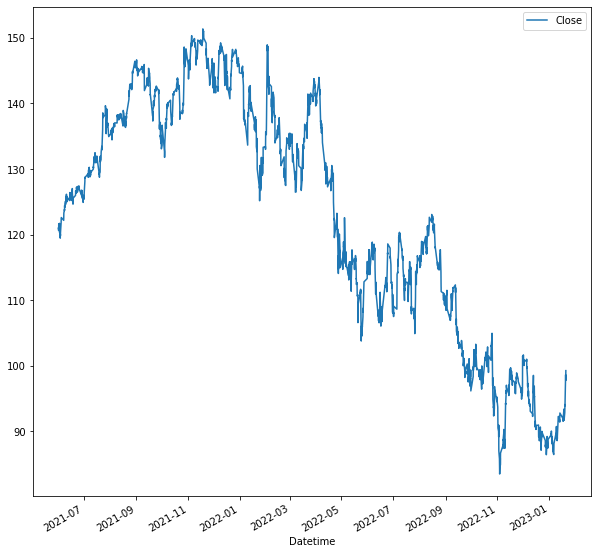

In [ ]:
data=yf.download('GOOG',start='2021-06-01', interval='1h',  end='2023-01-23',progress=False)[['Close']]
data.head()
  
data.plot(figsize=(10,10))

In [ ]:
cl = data.Close.astype('float32')
train = cl[0:int(len(cl)*0.80)]
scl = MinMaxScaler()
#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
 
 
lb=10
X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

2592 10
289 10
2592
289


In [ ]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
 
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
 
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300
81/81 [==============================] - 6s 9ms/step - loss: 0.0098 - val_loss: 0.0032
Epoch 2/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 6.9581e-04
Epoch 3/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 7.0365e-04
Epoch 4/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 6.7540e-04
Epoch 5/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 7.4209e-04
Epoch 6/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 6.7536e-04
Epoch 7/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 7.2131e-04
Epoch 8/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 6.3392e-04
Epoch 9/300
81/81 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 6.6600e-04
Epoch 10/300
81/81 [==============================] - 0s 5ms/step - loss: 0.0

81/81 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Train Dataset')

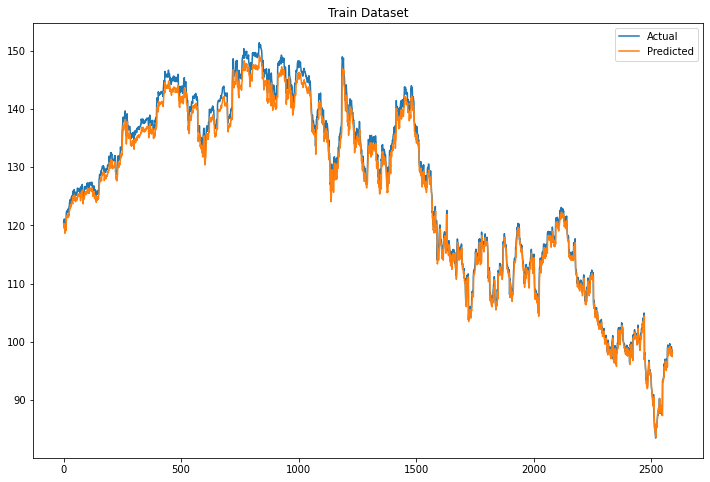

In [ ]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

10/10 [==============================] - 1s 4ms/step


Text(0.5, 1.0, 'Test Dataset')

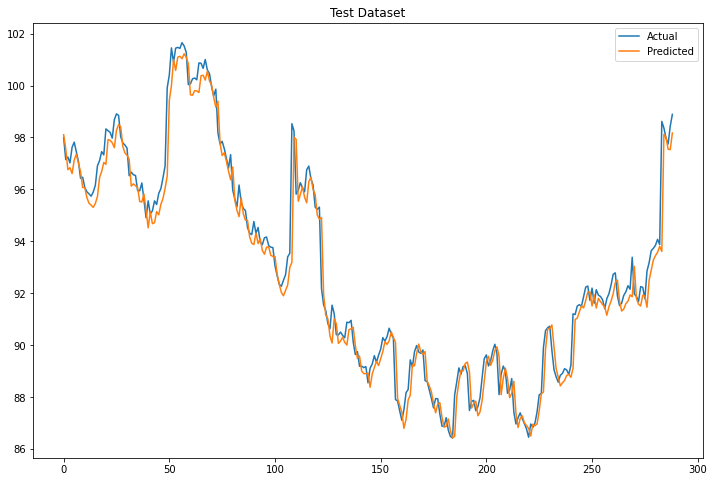

In [ ]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")

10/10 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Test Dataset 250 Obs Ahead')

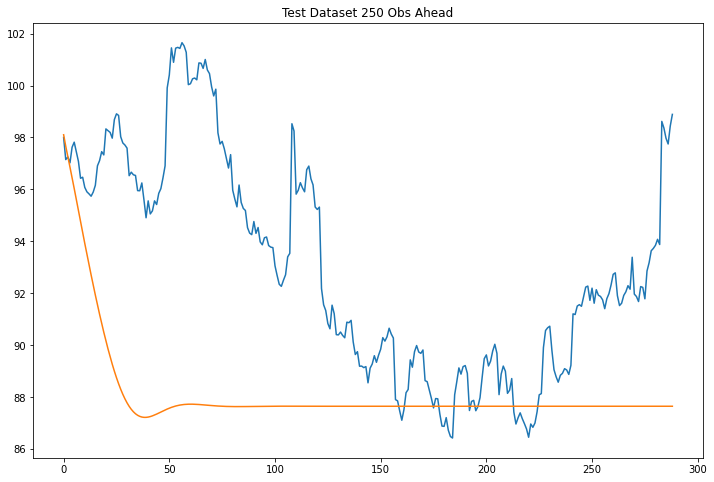

In [ ]:
def processData(data,lb):
    X= []
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
    return np.array(X)
 
# create the x_test_dummy
cl2 =cl.copy()
pred = []
for i in range(X_test.shape[0]):
    cl2[int(X.shape[0]*0.90)+i+lb] = model.predict(X_test)[i]
    pred.extend(model.predict(X_test)[i])
    X = processData(cl2,lb)
    X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
 
 
 
prediction = scl.inverse_transform(np.array(pred).reshape(-1, 1))
plt.figure(figsize=(12,8))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)),  label="Actual")
plt.plot(prediction, label="Predicted")
 
plt.title("Test Dataset 250 Obs Ahead")